# pipline
其中通过Numpy array, Pandas DataFrame, 文件路径构建数据管道是最常用的方法。

通过tfrecords文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecords文件，读取后再解析成tf.Example。

但tfrecords文件的优点是压缩后文件较小，便于网络传播，加载速度较快。

In [ ]:
# array
ds1 = tf.data.Dataset.from_tensor_slices((iris["data"],iris["target"]))

# pd
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict("list"),iris["target"]))

# generator
def generator():
    for features,label in image_generator:
        yield (features,label)

ds3 = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))

# csv
ds4 = tf.data.experimental.make_csv_dataset(
      file_pattern = ["./data/titanic/train.csv","./data/titanic/test.csv"],
      batch_size=3, 
      label_name="Survived",
      na_value="",
      num_epochs=1,
      ignore_errors=True)

# csv
ds5 = tf.data.TextLineDataset(
    filenames = ["./data/titanic/train.csv","./data/titanic/test.csv"]
    ).skip(1) #略去第一行header

# file path
ds6 = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")

# 从tfrecords文件构建数据管道


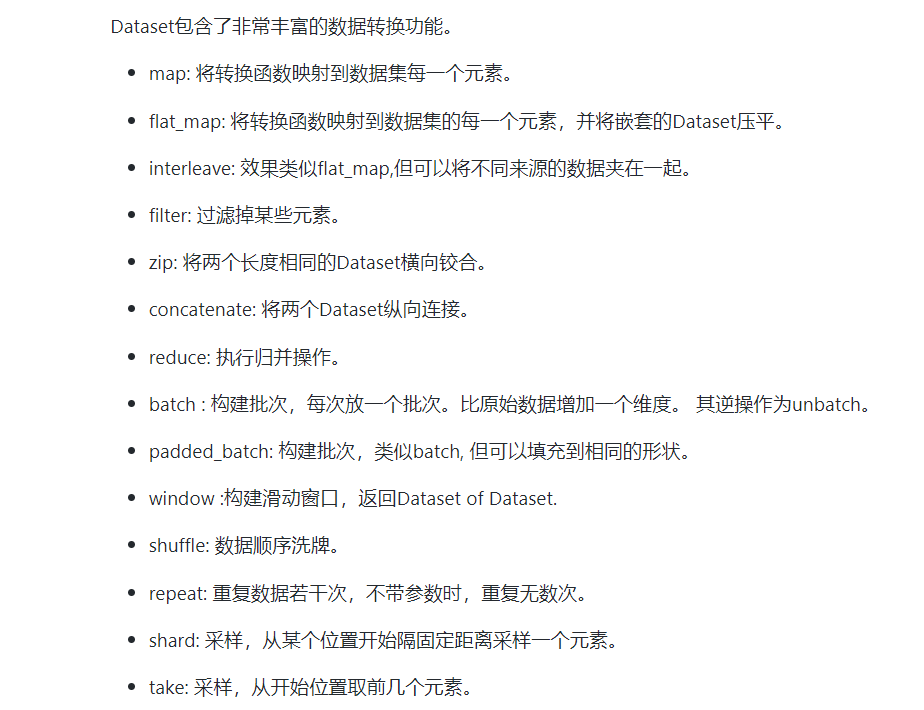

# tips

#### 1 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

#### 2 使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

In [ ]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.interleave(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(8):
    print(line)

#### 3 cache

In [ ]:
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32)).cache()

# feature columns

In [5]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")

In [14]:
dfraw = pd.concat([dftrain_raw,dftest_raw])

def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col,dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            # 添加标识是否缺失列
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            # 填充
ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)

In [22]:
dfraw.to_dict(orient='records') # orient : str {'dict', 'list', 'series', 'split', 'records', 'index'}

[{'PassengerId': 493,
  'Survived': 0,
  'Pclass': 1,
  'Name': 'Molson, Mr. Harry Markland',
  'Sex': 'male',
  'Age': 55.0,
  'SibSp': 0,
  'Parch': 0,
  'Ticket': '113787',
  'Fare': 30.5,
  'Cabin': 'C30',
  'Embarked': 'S'},
 {'PassengerId': 53,
  'Survived': 1,
  'Pclass': 1,
  'Name': 'Harper, Mrs. Henry Sleeper (Myna Haxtun)',
  'Sex': 'female',
  'Age': 49.0,
  'SibSp': 1,
  'Parch': 0,
  'Ticket': 'PC 17572',
  'Fare': 76.7292,
  'Cabin': 'D33',
  'Embarked': 'C'},
 {'PassengerId': 388,
  'Survived': 1,
  'Pclass': 2,
  'Name': 'Buss, Miss. Kate',
  'Sex': 'female',
  'Age': 36.0,
  'SibSp': 0,
  'Parch': 0,
  'Ticket': '27849',
  'Fare': 13.0,
  'Cabin': nan,
  'Embarked': 'S'},
 {'PassengerId': 192,
  'Survived': 0,
  'Pclass': 2,
  'Name': 'Carbines, Mr. William',
  'Sex': 'male',
  'Age': 19.0,
  'SibSp': 0,
  'Parch': 0,
  'Ticket': '28424',
  'Fare': 13.0,
  'Cabin': nan,
  'Embarked': 'S'},
 {'PassengerId': 687,
  'Survived': 0,
  'Pclass': 3,
  'Name': 'Panula, Mr. Ja

## 二，定义特征列

要创建特征列，请调用 tf.feature_column 模块的函数。该模块中常用的九个函数如下图所示，所有九个函数都会返回一个 Categorical-Column 或一个 Dense-Column 对象，但却不会返回 bucketized_column，后者继承自这两个类。

注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！

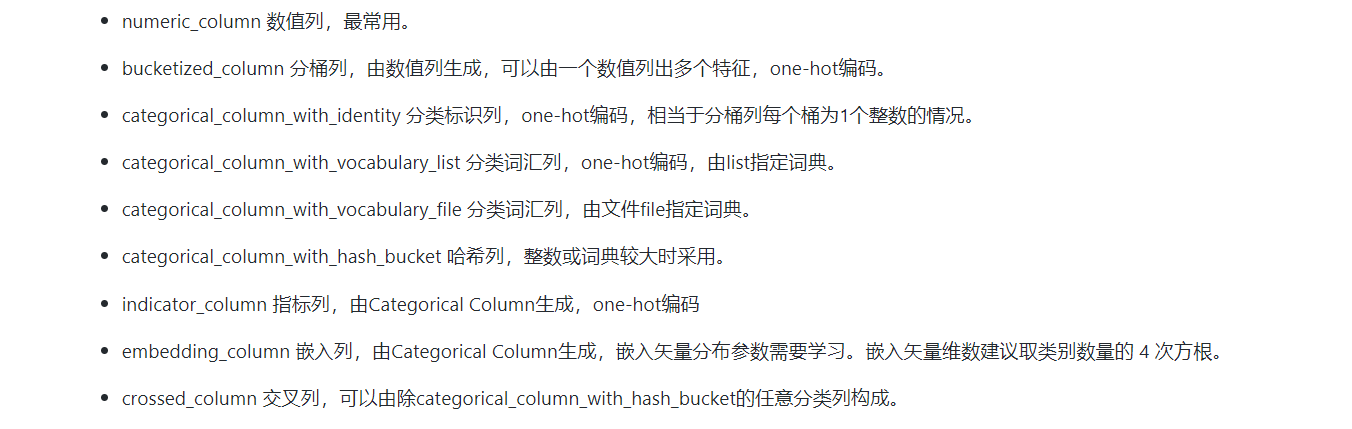


In [23]:
feature_columns = []

# 数值列
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

In [28]:
# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

In [29]:
ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])